In [60]:
from SimPEG import Mesh
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [159]:
# cell size, number of cells in the x-direction, 
# number of cells in the z-direction and number of padding cells
mesh_type = '2d_cyl'

if mesh_type== '2d_cyl':
    ncx = 10
    csx = 10.
    npadx = 15.
    ncz = 10.
    csz = 5.
    npadz = 18.
    hx = [(csx, ncx), (csx, npadx, 1.3)]
    hz = [(csz, npadz, -1.3), (csz, ncx), (csz, npadz, 1.3)]    
#     hz_pad_up = [(csz, npad, -1.3), (csz, ncz), (csz, 5., 1.3)]
#     log_spaced_z_cells = np.logspace(np.log10(1.), np.log10(200.), 20)
#     z_padding = log_spaced_z_cells[-1] * 1.3 ** np.arange(npad)
#     hz = np.r_[z_padding[::-1], log_spaced_z_cells[::-1], log_spaced_z_cells, z_padding]
    mesh = Mesh.CylMesh([hx, 1, hz], x0='00C')
elif mesh_type == '3d_tensor':
    cs, ncx, npad = 10., 9, 8    
    ncy = 1
    ncz = 6
    hx = [(cs, npad, -1.3), (cs, ncx), (cs, npad, 1.3)]
    hy = [(cs, npad, -1.3), (cs, ncy), (cs, npad, 1.3)]    
    hz = [(cs, npad, -1.3), (cs, ncz), (cs, npad, 1.3)]
    mesh = Mesh.TensorMesh([hx, hy, hz], 'CCC')
active = mesh.gridCC[:,2] < 0.
sigma_background = 1./100.
sigma = np.ones(mesh.nC)*1e-8
sigma[active] = sigma_background
rho = 1./sigma

In [160]:
from SimPEG import Utils

In [161]:
from pymatsolver import Pardiso
from SimPEG import EM
z_src = 30
x_rx = 0.
z_offset = 0.
rxloc = np.array([x_rx, 0., z_src+z_offset])
srcloc = np.array([0., 0., z_src])
rx = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-6), np.log10(1e-2), 31), 'z')
src = EM.TDEM.Src.CircularLoop([rx], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius=13.)
survey = EM.TDEM.Survey([src])
prb = EM.TDEM.Problem3D_e(mesh, rho=rho, verbose=True)
prb.timeSteps = [(1e-7, 5),(3e-7, 5),(1e-6, 5),(2e-6, 5),(5e-6, 5),(1e-5, 10),(3e-5, 10),(1e-4, 10),(3e-4, 5),(1e-3, 8)]
# prb.timeSteps = [(1e-6, 5),(1e-5, 10),(1e-4, 10),(1e-3, 10)]
prb.Solver = Pardiso
prb.pair(survey)
data = survey.dpred([])

/Users/sgkang/Projects/simpeg/SimPEG/Props.py:400: UserWarning: Cannot add model as there are no active mappings, choose from: ['rhoMap', 'sigmaMap']
  "', '".join(self._all_map_names)


Calculating Initial fields
**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 1.000000e-07)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
Factoring...   (dt = 3.000000e-07)
Done
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
Factoring...   (dt = 1.000000e-06)
Done
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
Factoring...   (dt = 2.000000e-06)
Done
    Solving...   (tInd = 16)
    Done...
    Solving...   (tInd = 17)
    Done...
 

In [162]:
# x = np.linspace(10, 100, 10)
# y = np.zeros_like(x)
# z = np.ones_like(x) * 30.
# Fz = mesh.getInterpolationMat(np.c_[x, y, z], locType='Fz')
# b0 = src.bInitial(prb)
# bz = Fz*b0
# bza = -1./(4*np.pi*x**3) * mu_0
# plt.semilogy(x, -bz/(np.pi/2), 'k-', )
# plt.semilogy(x, -bz, 'k--', )
# plt.semilogy(x, -bza, 'kx')

In [163]:
from simpegEM1D import (
    EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, 
    set_mesh_1d, skytem_HM_2015
)
from SimPEG import Maps
time = rx.times

def aem_simulation(
    rho_background,
    rho_target,
    z, 
    h
):
    rho  = np.array([rho_background, rho_target, rho_background])
    sigma = 1./rho
    hz = np.array([z, h, 500-z-h])    
    mesh1D = set_mesh_1d(hz)
    depth = -mesh1D.gridN[:-1]
    LocSigZ = -mesh1D.gridCC
    TDsurvey = EM1DSurveyTD(
        rx_location = np.array([0., 0., 100.+z_src]),
        src_location = np.array([0., 0., 100.+z_src]),
        topo = np.r_[0., 0., 100.],
        depth = depth,
        rx_type = 'dBzdt',
        wave_type = 'stepoff',
        src_type = 'CircularLoop',
        a=13.,
        I = 1.,
        time = time,
        use_lowpass_filter=False,
    )
    chi_half = 0.
    expmap = Maps.ExpMap(mesh1D)
    prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False)
    if prob.ispaired:
        prob.unpair()
    if TDsurvey.ispaired:
        TDsurvey.unpair()
    prob.pair(TDsurvey)
    prob.chi = np.zeros(TDsurvey.n_layer)
    data = TDsurvey.dpred(np.log(sigma))    
    return data, mesh1D, rho

In [164]:
data_analytic, _, _ = aem_simulation(1./sigma_background, 1./sigma_background, 10, 10)

In [165]:
# plt.loglog(rx.times, -data/(np.pi/2.), 'kx')
# plt.loglog(rx.times, -data_analytic, 'k')
# plt.loglog(prb.times, np.ones(prb.times.size)*1e-11, 'k|')

In [166]:
# data/data_analytic

In [167]:
def bdf1():
    # Operators
    C = mesh.edgeCurl
    Mfmui = mesh.getFaceInnerProduct(1./mu_0)
    MeSigma = mesh.getEdgeInnerProduct(sigma)
    n_steps = prb.timeSteps.size
    Fz = mesh.getInterpolationMat(rx.locs, locType='Fz')
    eps = 1e-10
    def getA(dt):
        return C.T*Mfmui*C + 1./dt * MeSigma
    dt_0 = 0.
    data_test = np.zeros(prb.timeSteps.size)
    sol_n0 = np.zeros(mesh.nE)
    sol_n1 = np.zeros(mesh.nE)

    for ii in range(n_steps):
        dt = prb.timeSteps[ii]
        A = getA(dt)
        if abs(dt_0-dt) > eps:
            Ainv = prb.Solver(A)
        if ii==0:        
            b0 = src.bInitial(prb)
            s_e = C.T*Mfmui*b0
            rhs = s_e/dt
        else:
            rhs = MeSigma*sol_n0/dt
        sol_n1 = Ainv*rhs
        data_test[ii] = Fz*(-C*sol_n1)
        dt_0 = dt
        sol_n0 = sol_n1.copy()    
    P = prb.timeMesh.getInterpolationMat(rx.times)
    return P*data_test        

In [168]:
def bdf2():
    # Operators
    C = mesh.edgeCurl
    Mfmui = mesh.getFaceInnerProduct(1./mu_0)
    MeSigma = mesh.getEdgeInnerProduct(sigma)
    n_steps = prb.timeSteps.size
    Fz = mesh.getInterpolationMat(rx.locs, locType='Fz')
    eps = 1e-10
    def getA(dt, factor=1.):
        return C.T*Mfmui*C + factor/dt * MeSigma
    dt_0 = 0.
    data_test = np.zeros(prb.timeSteps.size)
    sol_n0 = np.zeros(mesh.nE)
    sol_n1 = np.zeros(mesh.nE)
    sol_n2 = np.zeros(mesh.nE)
    for ii in range(n_steps):
        dt = prb.timeSteps[ii]
        #Factor for BDF2
        factor=3/2.            
        if abs(dt_0-dt) > eps:
            print (ii, factor)
            A = getA(dt, factor=factor)            
            Ainv = prb.Solver(A)
        if ii==0:        
            b0 = src.bInitial(prb)
            s_e = C.T*Mfmui*b0
            rhs = factor/dt*s_e
        elif ii==1:
            rhs = -factor/dt*(MeSigma*(-4/3.*sol_n1+1/3.*sol_n0) + 1./3.*s_e)
        else:
            rhs = -factor/dt*(MeSigma*(-4/3.*sol_n1+1/3.*sol_n0))
        sol_n2 = Ainv*rhs
        data_test[ii] = Fz*(-C*sol_n2)
        dt_0 = dt
        sol_n0 = sol_n1.copy()            
        sol_n1 = sol_n2.copy()    

    P = prb.timeMesh.getInterpolationMat(rx.times)
    return P*data_test        

In [169]:
temp1 = bdf1()

In [170]:
temp2 = bdf2()

0 1.5
5 1.5
10 1.5
15 1.5
20 1.5
25 1.5
35 1.5
45 1.5
55 1.5
60 1.5


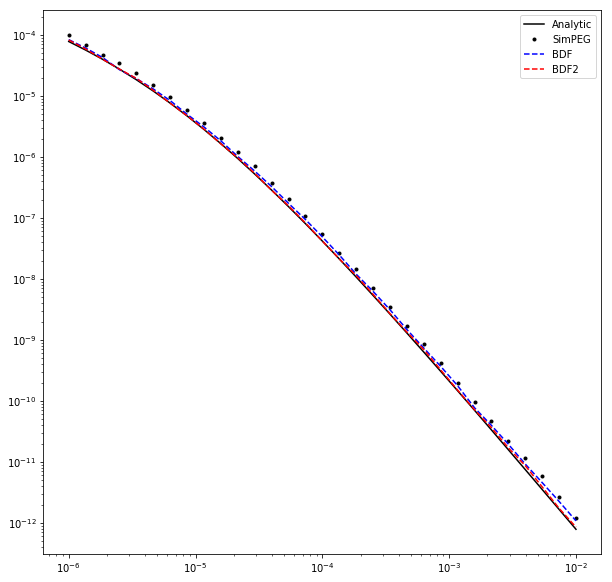

In [173]:
plt.figure(figsize = (10, 10))
plt.loglog(rx.times, -data_analytic, 'k')
plt.loglog(rx.times, -data, 'k.')
plt.loglog(rx.times, -temp1, 'b--')
plt.loglog(rx.times, -temp2, 'r--')
plt.legend(("Analytic", "SimPEG", "BDF", "BDF2"))

In [140]:
np.linalg.norm((data_analytic-temp1)/data_analytic)

1.0334876668069195

In [141]:
np.linalg.norm((data_analytic-temp2)/data_analytic)

0.4262667989334051

In [142]:
np.linalg.norm((data_analytic-data)/data_analytic)

2.1390153776285525